<a href="https://colab.research.google.com/github/bayowasolomon/CONDA/blob/main/PLAG_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns




In [10]:
import pickle
import os

# Define a filename for your model
model_filename = 'plag_classifier_model.pkl'

# Check if the classifier object exists (assuming 'classifier' was returned by run_snli_classification)
if 'classifier' in locals() and hasattr(classifier, 'model'):
    # Ensure the directory exists
    os.makedirs(os.path.dirname(model_filename) or '.', exist_ok=True)

    # Save the trained model to the file
    with open(model_filename, 'wb') as f:
        pickle.dump(classifier, f)

    print(f"Model saved successfully to {model_filename}")
else:
    print("Classifier object not found. Please run the training cell first.")

Model saved successfully to plag_classifier_model.pkl


In [3]:
from google.colab import files
uploaded = files.upload()

Saving train_snli.txt to train_snli.txt


In [4]:
import io

# The dataset is a txt file.
filename = next(iter(uploaded))
try:
  df = pd.read_csv(io.BytesIO(uploaded[filename]), sep='\t', header=None, names=['text', 'label']) # Added 'label' based on previous outputs
  print(f"Successfully read {filename} into a DataFrame.")
  display(df.head())
  display(df.info())
except Exception as e:
  print(f"Could not read {filename} into a DataFrame. Please check the file format and adjust the code.")
  print(e)

Successfully read train_snli.txt into a DataFrame.


,text,label
A person on a horse jumps over a broken down airplane.,"A person is at a diner, ordering an omelette.",0
A person on a horse jumps over a broken down airplane.,"A person is outdoors, on a horse.",1
Children smiling and waving at camera,There are children present,1
Children smiling and waving at camera,The kids are frowning,0
A boy is jumping on skateboard in the middle of a red bridge.,The boy skates down the sidewalk.,0


<class 'pandas.core.frame.DataFrame'>
Index: 367373 entries, A person on a horse jumps over a broken down airplane. to A man is surfing in a bodysuit in beautiful blue water.
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    367369 non-null  object
 1   label   367373 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 8.4+ MB


None

Running on sample data...

To use with your actual data, run:
classifier, results = run_snli_classification(df)
TEXT CLASSIFICATION WITH TF-IDF - SNLI DATASET
Dataset size after cleaning: 1000
Label distribution:
label
0    600
1    400
Name: count, dtype: int64

Training set size: 700
Test set size: 300
Vectorizing training data...
TF-IDF shape: (700, 45)
Vocabulary size: 45

Training logistic classifier...
Training complete!

EVALUATION RESULTS

Accuracy: 0.8033

Classification Report:
              precision    recall  f1-score     support
0              1.000000  0.672222  0.803987  180.000000
1              0.670391  1.000000  0.802676  120.000000
accuracy       0.803333  0.803333  0.803333    0.803333
macro avg      0.835196  0.836111  0.803331  300.000000
weighted avg   0.868156  0.803333  0.803462  300.000000


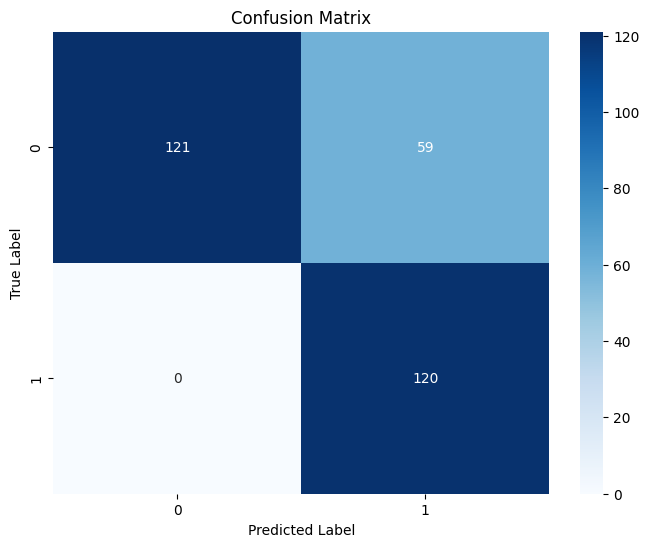


TOP FEATURES BY CLASS

Class 0 - Top 10 features:
  boy: -1.3216
  frowning: -1.3026
  kids: -1.3026
  kids frowning: -1.3026
  boy skates: -1.0224
  skates sidewalk: -1.0224
  sidewalk: -1.0224
  skates: -1.0224
  omelette: -0.9763
  person diner: -0.9763

Class 1 - Top 10 features:
  present: 2.4735
  children present: 2.4735
  person outdoors: 2.0384
  outdoors horse: 2.0384
  outdoors: 2.0384
  children: 1.8285
  horse: 1.5295
  person: 0.7657
  children smiling: 0.2373
  smiling: 0.2373


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

class SNLIClassifier:
    """
    Text classification model using TF-IDF for SNLI-style datasets.
    Handles premise-hypothesis pairs to predict entailment/contradiction.
    """

    def __init__(self, model_type='logistic', ngram_range=(1, 2)):
        """
        Initialize classifier.

        Args:
            model_type: 'logistic' or 'svm'
            ngram_range: Range of n-grams to use (default: unigrams and bigrams)
        """
        self.vectorizer = TfidfVectorizer(
            ngram_range=ngram_range,
            stop_words='english',
            lowercase=True,
            max_df=0.9,
            min_df=5,
            max_features=10000
        )

        if model_type == 'logistic':
            self.model = LogisticRegression(max_iter=1000, random_state=42)
        elif model_type == 'svm':
            self.model = LinearSVC(random_state=42, max_iter=1000)
        else:
            raise ValueError("model_type must be 'logistic' or 'svm'")

        self.model_type = model_type
        self.is_fitted = False

    def preprocess_data(self, df):
        """
        Preprocess SNLI dataframe.

        Args:
            df: DataFrame with 'text' and 'label' columns

        Returns:
            Cleaned DataFrame
        """
        # Remove null values
        df = df.dropna(subset=['text', 'label'])

        # Ensure labels are integers
        df['label'] = df['label'].astype(int)

        print(f"Dataset size after cleaning: {len(df)}")
        print(f"Label distribution:\n{df['label'].value_counts().sort_index()}")

        return df

    def train(self, X_train, y_train):
        """
        Train the classifier.

        Args:
            X_train: Training text data
            y_train: Training labels
        """
        print("Vectorizing training data...")
        X_train_tfidf = self.vectorizer.fit_transform(X_train)

        print(f"TF-IDF shape: {X_train_tfidf.shape}")
        print(f"Vocabulary size: {len(self.vectorizer.vocabulary_)}")

        print(f"\nTraining {self.model_type} classifier...")
        self.model.fit(X_train_tfidf, y_train)

        self.is_fitted = True
        print("Training complete!")

    def predict(self, X_test):
        """
        Make predictions on test data.

        Args:
            X_test: Test text data

        Returns:
            Predictions array
        """
        if not self.is_fitted:
            raise ValueError("Model not trained. Call train() first.")

        X_test_tfidf = self.vectorizer.transform(X_test)
        return self.model.predict(X_test_tfidf)

    def predict_proba(self, X_test):
        """
        Get prediction probabilities (only for logistic regression).

        Args:
            X_test: Test text data

        Returns:
            Probability array
        """
        if self.model_type != 'logistic':
            raise ValueError("Probabilities only available for logistic regression")

        X_test_tfidf = self.vectorizer.transform(X_test)
        return self.model.predict_proba(X_test_tfidf)

    def evaluate(self, X_test, y_test):
        """
        Evaluate model performance.

        Args:
            X_test: Test text data
            y_test: True labels

        Returns:
            Dictionary with evaluation metrics
        """
        y_pred = self.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)

        return {
            'accuracy': accuracy,
            'classification_report': report,
            'confusion_matrix': cm,
            'predictions': y_pred
        }

    def plot_confusion_matrix(self, cm, labels=None):
        """
        Plot confusion matrix.

        Args:
            cm: Confusion matrix
            labels: Class labels
        """
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels, yticklabels=labels)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    def get_top_features(self, class_label, top_n=20):
        """
        Get top features for a specific class.

        Args:
            class_label: Class to analyze (0 or 1 for binary)
            top_n: Number of top features to return

        Returns:
            List of (feature, coefficient) tuples
        """
        if self.model_type == 'logistic':
            feature_names = self.vectorizer.get_feature_names_out()

            # Handle binary vs multiclass classification
            if len(self.model.coef_.shape) == 1 or self.model.coef_.shape[0] == 1:
                # Binary classification - single coefficient vector
                coef = self.model.coef_[0]
                if class_label == 0:
                    # Negative coefficients favor class 0
                    top_indices = np.argsort(coef)[:top_n]
                else:
                    # Positive coefficients favor class 1
                    top_indices = np.argsort(coef)[-top_n:][::-1]
            else:
                # Multiclass classification
                coef = self.model.coef_[class_label]
                top_indices = np.argsort(coef)[-top_n:][::-1]

            return [(feature_names[i], coef[i]) for i in top_indices]
        else:
            raise ValueError("Feature importance only available for logistic regression")



def run_snli_classification(df, test_size=0.2, model_type='logistic'):
    """
    Complete pipeline for SNLI classification.

    Args:
        df: DataFrame with 'text' and 'label' columns
        test_size: Proportion of data for testing
        model_type: 'logistic' or 'svm'
    """
    print("="*70)
    print("TEXT CLASSIFICATION WITH TF-IDF - SNLI DATASET")
    print("="*70)

    # Initialize classifier
    classifier = SNLIClassifier(model_type=model_type)

    # Preprocess
    df = classifier.preprocess_data(df)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        df['text'], df['label'],
        test_size=test_size,
        random_state=42,
        stratify=df['label']
    )

    print(f"\nTraining set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")

    # Train
    classifier.train(X_train, y_train)

    # Evaluate
    print("\n" + "="*70)
    print("EVALUATION RESULTS")
    print("="*70)

    results = classifier.evaluate(X_test, y_test)

    print(f"\nAccuracy: {results['accuracy']:.4f}")
    print("\nClassification Report:")
    print(pd.DataFrame(results['classification_report']).transpose())

    # Plot confusion matrix
    labels = sorted(df['label'].unique())
    classifier.plot_confusion_matrix(results['confusion_matrix'], labels=labels)

    # Show top features for each class (if logistic regression)
    if model_type == 'logistic':
        print("\n" + "="*70)
        print("TOP FEATURES BY CLASS")
        print("="*70)

        for label in labels:
            print(f"\nClass {label} - Top 10 features:")
            top_features = classifier.get_top_features(label, top_n=10)
            for feature, coef in top_features:
                print(f"  {feature}: {coef:.4f}")

    return classifier, results


# Quick test with sample data
if __name__ == "__main__":
    # Create sample data similar to SNLI format
    sample_data = {
        'text': [
            "A person on a horse jumps over a broken down airplane.",
            "A person is at a diner, ordering an omelette.",
            "A person on a horse jumps over a broken down airplane.",
            "A person is outdoors, on a horse.",
            "Children smiling and waving at camera",
            "There are children present",
            "Children smiling and waving at camera",
            "The kids are frowning",
            "A boy is jumping on skateboard in the middle of a red bridge.",
            "The boy skates down the sidewalk."
        ] * 100,  # Repeat for demo
        'label': [0, 0, 1, 1, 1, 1, 0, 0, 0, 0] * 100
    }

    df_sample = pd.DataFrame(sample_data)

    print("Running on sample data...")
    print("\nTo use with your actual data, run:")
    print("classifier, results = run_snli_classification(df)")

    # Uncomment to run on sample:
    classifier, results = run_snli_classification(df_sample, test_size=0.3)

TEXT CLASSIFICATION WITH TF-IDF - SNLI DATASET
Dataset size after cleaning: 367369
Label distribution:
label
0    183964
1    183405
Name: count, dtype: int64


/tmp/ipython-input-256127271.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].astype(int)



Training set size: 293895
Test set size: 73474
Vectorizing training data...
TF-IDF shape: (293895, 10000)
Vocabulary size: 10000

Training logistic classifier...
Training complete!

EVALUATION RESULTS

Accuracy: 0.7302

Classification Report:
              precision    recall  f1-score       support
0              0.738865  0.713261  0.725837  36793.000000
1              0.722047  0.747144  0.734381  36681.000000
accuracy       0.730177  0.730177  0.730177      0.730177
macro avg      0.730456  0.730202  0.730109  73474.000000
weighted avg   0.730469  0.730177  0.730103  73474.000000


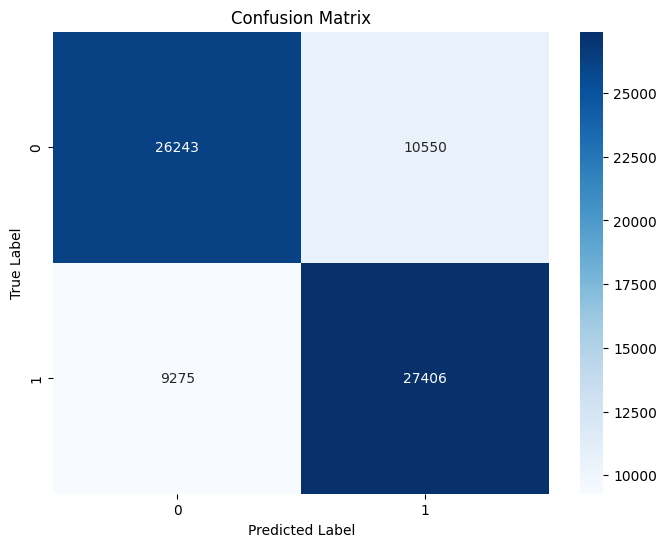


TOP FEATURES BY CLASS

Class 0 - Top 10 features:
  sleeping: -5.9821
  cats: -5.6408
  naked: -5.5019
  moon: -5.4393
  frowning: -5.2915
  cat: -5.1714
  funeral: -4.8798
  home: -4.8517
  mars: -4.8014
  quietly: -4.6550

Class 1 - Top 10 features:
  outdoors: 5.5060
  human: 5.4240
  humans: 4.3837
  outside: 3.6882
  near: 3.2916
  making music: 3.1717
  animal: 3.0361
  animals running: 3.0300
  somebody: 2.8882
  motion: 2.8809


In [6]:
# Run classification
classifier, results = run_snli_classification(df, test_size=0.2, model_type='logistic')

In [7]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

class AdvancedTFIDFClassifier:
    """
    Advanced text classification using TF-IDF with multiple optimization techniques.
    """

    def __init__(self, model_type='logistic', vectorizer_params=None, model_params=None):
        """
        Initialize classifier with custom parameters.

        Args:
            model_type: 'logistic', 'svm', 'rf', 'gb', or 'nb'
            vectorizer_params: Dict of TfidfVectorizer parameters
            model_params: Dict of model-specific parameters
        """
        # Default vectorizer parameters
        default_vec_params = {
            'ngram_range': (1, 2),
            'stop_words': 'english',
            'lowercase': True,
            'max_df': 0.9,
            'min_df': 5,
            'max_features': 10000,
            'sublinear_tf': True  # Use log scaling for term frequency
        }

        if vectorizer_params:
            default_vec_params.update(vectorizer_params)

        self.vectorizer = TfidfVectorizer(**default_vec_params)

        # Initialize model based on type
        if model_type == 'logistic':
            default_model_params = {'max_iter': 1000, 'random_state': 42, 'C': 1.0}
            if model_params:
                default_model_params.update(model_params)
            self.model = LogisticRegression(**default_model_params)

        elif model_type == 'svm':
            default_model_params = {'random_state': 42, 'max_iter': 1000, 'C': 1.0}
            if model_params:
                default_model_params.update(model_params)
            self.model = LinearSVC(**default_model_params)

        elif model_type == 'rf':
            default_model_params = {'n_estimators': 100, 'random_state': 42, 'n_jobs': -1}
            if model_params:
                default_model_params.update(model_params)
            self.model = RandomForestClassifier(**default_model_params)

        elif model_type == 'gb':
            default_model_params = {'n_estimators': 100, 'random_state': 42, 'learning_rate': 0.1}
            if model_params:
                default_model_params.update(model_params)
            self.model = GradientBoostingClassifier(**default_model_params)

        elif model_type == 'nb':
            self.model = MultinomialNB()
        else:
            raise ValueError("model_type must be 'logistic', 'svm', 'rf', 'gb', or 'nb'")

        self.model_type = model_type
        self.is_fitted = False

    def preprocess_text(self, text):
        """
        Advanced text preprocessing.

        Args:
            text: Input text string

        Returns:
            Cleaned text
        """
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def add_custom_features(self, texts, labels=None):
        """
        Add custom hand-crafted features to TF-IDF vectors.

        Args:
            texts: List of text strings
            labels: Optional labels (for training data analysis)

        Returns:
            Feature matrix with additional features
        """
        custom_features = []

        for text in texts:
            features = {
                'length': len(text),
                'word_count': len(text.split()),
                'avg_word_length': np.mean([len(word) for word in text.split()]) if text.split() else 0,
                'exclamation_count': text.count('!'),
                'question_count': text.count('?'),
                'uppercase_ratio': sum(1 for c in text if c.isupper()) / len(text) if len(text) > 0 else 0,
                'digit_count': sum(1 for c in text if c.isdigit()),
            }
            custom_features.append(list(features.values()))

        return np.array(custom_features)

    def train(self, X_train, y_train, use_custom_features=False):
        """
        Train the classifier.

        Args:
            X_train: Training text data
            y_train: Training labels
            use_custom_features: Whether to add custom features
        """
        print("Preprocessing text...")
        X_train_clean = [self.preprocess_text(str(text)) for text in X_train]

        print("Vectorizing training data...")
        X_train_tfidf = self.vectorizer.fit_transform(X_train_clean)

        if use_custom_features:
            print("Adding custom features...")
            custom_feats = self.add_custom_features(X_train_clean)
            X_train_tfidf = np.hstack([X_train_tfidf.toarray(), custom_feats])

        print(f"Feature matrix shape: {X_train_tfidf.shape}")
        print(f"Vocabulary size: {len(self.vectorizer.vocabulary_)}")

        print(f"\nTraining {self.model_type} classifier...")
        self.model.fit(X_train_tfidf, y_train)

        self.is_fitted = True
        self.use_custom_features = use_custom_features
        print("Training complete!")

    def predict(self, X_test):
        """Make predictions on test data."""
        if not self.is_fitted:
            raise ValueError("Model not trained. Call train() first.")

        X_test_clean = [self.preprocess_text(str(text)) for text in X_test]
        X_test_tfidf = self.vectorizer.transform(X_test_clean)

        if self.use_custom_features:
            custom_feats = self.add_custom_features(X_test_clean)
            X_test_tfidf = np.hstack([X_test_tfidf.toarray(), custom_feats])

        return self.model.predict(X_test_tfidf)

    def evaluate(self, X_test, y_test):
        """Evaluate model performance."""
        y_pred = self.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)

        return {
            'accuracy': accuracy,
            'classification_report': report,
            'confusion_matrix': cm,
            'predictions': y_pred
        }

    def cross_validate(self, X, y, cv=5):
        """
        Perform cross-validation.

        Args:
            X: All text data
            y: All labels
            cv: Number of folds

        Returns:
            Cross-validation scores
        """
        print(f"Performing {cv}-fold cross-validation...")
        X_clean = [self.preprocess_text(str(text)) for text in X]
        X_tfidf = self.vectorizer.fit_transform(X_clean)

        scores = cross_val_score(self.model, X_tfidf, y, cv=cv, scoring='accuracy')

        print(f"Cross-validation scores: {scores}")
        print(f"Mean accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

        return scores


def hyperparameter_tuning(X_train, y_train, model_type='logistic'):
    """
    Perform hyperparameter tuning using GridSearchCV.

    Args:
        X_train: Training text data
        y_train: Training labels
        model_type: Type of model to tune

    Returns:
        Best classifier
    """
    print(f"Performing hyperparameter tuning for {model_type}...")

    # Define pipeline
    if model_type == 'logistic':
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('clf', LogisticRegression(max_iter=1000, random_state=42))
        ])

        param_grid = {
            'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
            'tfidf__max_features': [5000, 10000, 15000],
            'tfidf__sublinear_tf': [True, False],
            'clf__C': [0.1, 1.0, 10.0]
        }

    elif model_type == 'svm':
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('clf', LinearSVC(random_state=42, max_iter=1000))
        ])

        param_grid = {
            'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
            'tfidf__max_features': [5000, 10000],
            'clf__C': [0.1, 1.0, 10.0]
        }

    elif model_type == 'rf':
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
        ])

        param_grid = {
            'tfidf__ngram_range': [(1, 1), (1, 2)],
            'tfidf__max_features': [5000, 10000],
            'clf__n_estimators': [50, 100, 200],
            'clf__max_depth': [10, 20, None]
        }

    # Perform grid search
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_


def compare_models(X_train, X_test, y_train, y_test):
    """
    Compare different models on the same dataset.

    Args:
        X_train, X_test: Training and test text data
        y_train, y_test: Training and test labels

    Returns:
        DataFrame with comparison results
    """
    models = {
        'Logistic Regression': 'logistic',
        'Linear SVM': 'svm',
        'Naive Bayes': 'nb',
        'Random Forest': 'rf'
    }

    results = []

    for name, model_type in models.items():
        print(f"\n{'='*60}")
        print(f"Training {name}...")
        print('='*60)

        classifier = AdvancedTFIDFClassifier(model_type=model_type)
        classifier.train(X_train, y_train)

        eval_results = classifier.evaluate(X_test, y_test)

        results.append({
            'Model': name,
            'Accuracy': eval_results['accuracy'],
            'Precision (weighted)': eval_results['classification_report']['weighted avg']['precision'],
            'Recall (weighted)': eval_results['classification_report']['weighted avg']['recall'],
            'F1-Score (weighted)': eval_results['classification_report']['weighted avg']['f1-score']
        })

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Accuracy', ascending=False)

    print("\n" + "="*60)
    print("MODEL COMPARISON")
    print("="*60)
    print(results_df.to_string(index=False))

    return results_df


# =============================================================================
# COMPLETE WORKFLOW EXAMPLE
# =============================================================================

def complete_workflow(df, test_size=0.2):
    """
    Complete workflow from data to optimized model.

    Args:
        df: DataFrame with 'text' and 'label' columns
        test_size: Test set proportion
    """
    print("="*70)
    print("ADVANCED TEXT CLASSIFICATION WORKFLOW")
    print("="*70)

    # Clean data
    df = df.dropna(subset=['text', 'label'])
    df['label'] = df['label'].astype(int)

    print(f"\nDataset size: {len(df)}")
    print(f"Label distribution:\n{df['label'].value_counts()}")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        df['text'], df['label'],
        test_size=test_size,
        random_state=42,
        stratify=df['label']
    )

    # Step 1: Compare different models
    print("\n" + "="*70)
    print("STEP 1: COMPARING DIFFERENT MODELS")
    print("="*70)
    comparison = compare_models(X_train, X_test, y_train, y_test)

    # Step 2: Hyperparameter tuning on best model
    best_model = comparison.iloc[0]['Model']
    model_map = {
        'Logistic Regression': 'logistic',
        'Linear SVM': 'svm',
        'Random Forest': 'rf',
        'Naive Bayes': 'nb'
    }

    print("\n" + "="*70)
    print(f"STEP 2: TUNING {best_model}")
    print("="*70)

    # Use smaller sample for tuning to save time
    sample_size = min(50000, len(X_train))
    X_train_sample = X_train.iloc[:sample_size]
    y_train_sample = y_train.iloc[:sample_size]

    best_pipeline = hyperparameter_tuning(
        X_train_sample,
        y_train_sample,
        model_map[best_model]
    )

    # Step 3: Evaluate tuned model
    print("\n" + "="*70)
    print("STEP 3: FINAL EVALUATION")
    print("="*70)

    y_pred = best_pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"\nFinal Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return best_pipeline, comparison


# Quick example usage
if __name__ == "__main__":
    print("To use with your SNLI data:")
    print("best_model, comparison = complete_workflow(df)")
    print("\nOr for quick model comparison:")
    print("comparison = compare_models(X_train, X_test, y_train, y_test)")

To use with your SNLI data:
best_model, comparison = complete_workflow(df)

Or for quick model comparison:
comparison = compare_models(X_train, X_test, y_train, y_test)


In [8]:
# Compare Logistic Regression, SVM, Naive Bayes, and Random Forest
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

comparison = compare_models(X_train, X_test, y_train, y_test)


Training Logistic Regression...
Preprocessing text...
Vectorizing training data...
Feature matrix shape: (293898, 10000)
Vocabulary size: 10000

Training logistic classifier...
Training complete!

Training Linear SVM...
Preprocessing text...
Vectorizing training data...
Feature matrix shape: (293898, 10000)
Vocabulary size: 10000

Training svm classifier...
Training complete!

Training Naive Bayes...
Preprocessing text...
Vectorizing training data...
Feature matrix shape: (293898, 10000)
Vocabulary size: 10000

Training nb classifier...
Training complete!

Training Random Forest...
Preprocessing text...
Vectorizing training data...
Feature matrix shape: (293898, 10000)
Vocabulary size: 10000

Training rf classifier...
Training complete!

MODEL COMPARISON
              Model  Accuracy  Precision (weighted)  Recall (weighted)  F1-Score (weighted)
Logistic Regression  0.731569              0.731866           0.731569             0.731494
         Linear SVM  0.730493              0.73113